# Tech Challenge - Fase 2

Grupo 13

João Luiz Pereira de Freitas – RM 358102

Taiany Soares Ribeiro Giacomeli – RM 358555

# Objetivo

O objetivo desse projeto é a criação de um modelo preditivo com dados da IBOVESPA, que seja capaz de realizar a previsão diária com uma acuracidade acima de 70%

# Bibliotecas



```
# Isto está formatado como código
```



In [ ]:
# Ver as versões das bibliotecas instaladas
!pip list

# Ver a versão do python
# !python --version

Python 3.11.12


In [ ]:
# Vamos começar com a instalação da versão 1.5.0 da biblioteca statsforecast, pois houveram algums bugs quando utilizamos a versão mais recente.

!pip install 'statsforecast==1.5.0'

In [ ]:
# Aqui estão todas as bibliotecas que utilizaremos ao longo deste projeto.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA

from scipy.signal import periodogram

# Análise Exploratória

In [ ]:
# Após a importação da biblioteca, vamos subir o nosso dataframe com os dados da IBOVESPA (arquivo disponível dentro da mesma pasta .zip onde esta localizado este notebook).

df_ibov = pd.read_csv('/content/Dados Históricos - Ibovespa - 2005_1_1.csv', sep=',')
df_ibov.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,14.11.2024,127.792,127.734,128.423,127.389,"13,14B","0,05%"
1,13.11.2024,127.734,127.698,128.100,126.869,"12,69B","0,03%"
2,12.11.2024,127.698,127.873,128.210,127.411,"9,52B","-0,14%"
3,11.11.2024,127.874,127.829,128.095,127.306,"8,40B","0,03%"
4,08.11.2024,127.830,129.647,129.647,126.973,"13,18B","-1,43%"


In [ ]:
# Conforme podemos ver pelo método head e tail, nossos dados começam em 03/01/2005, e vão até 14/11/2024.

df_ibov.tail()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
4920,07.01.2005,24.747,24.376,24.874,24.376,"104,96M","1,56%"
4921,06.01.2005,24.367,24.695,24.808,24.250,"151,17M","-1,32%"
4922,05.01.2005,24.692,24.859,25.001,24.523,"127,42M","-0,63%"
4923,04.01.2005,24.848,25.722,25.873,24.791,"146,14M","-3,40%"
4924,03.01.2005,25.722,26.193,26.492,25.671,"115,64M","-1,81%"


In [ ]:
df_ibov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4925 entries, 0 to 4924
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4925 non-null   object 
 1   Último    4925 non-null   float64
 2   Abertura  4925 non-null   float64
 3   Máxima    4925 non-null   float64
 4   Mínima    4925 non-null   float64
 5   Vol.      4924 non-null   object 
 6   Var%      4925 non-null   object 
dtypes: float64(4), object(3)
memory usage: 269.5+ KB


In [ ]:
df_ibov.isnull().sum()

,0
Data,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,1
Var%,0


Aqui já podemos tirar as seguintes conclusões:

1 - Baseado nos métodos 'head' e 'tail', vemos que os dados estão padronizados, e não parece haver nenhum tipo de dado indesejado nem no começo e nem no final do dataframe.

2 - Precisamos tratar o '.' dos valores das colunas Último, Abertura, Máxima e Mínima, pois o python entende ele como separador decimal.

2 - Baseado no método 'info', vemos que as colunas 'Data', 'Vol.' e 'Var%' estão classificadas como 'object', e vamos precisar tratá-las.

3 - Baseado no método 'isnull', vemos que existe apenas um valor nulo na coluna 'Vol.', e vamos precisar tratá-lo.

In [ ]:
# Primeiro vamos trazer os nossos dados novamente, agora utilizando o parse_dates e index_col para trazer a nossa coluna de data como DatetimeIndex. Também vamos especificar nossos separadores para evitar problemas com os valores numéricos.

df_ibov = pd.read_csv('/content/Dados Históricos - Ibovespa - 2005_1_1.csv', sep=',', parse_dates=[0], index_col='Data', decimal=',', thousands='.')
df_ibov.head()

<ipython-input-11-899897b026ca>:3: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_ibov = pd.read_csv('/content/Dados Históricos - Ibovespa - 2005_1_1.csv', sep=',', parse_dates=[0], index_col='Data', decimal=',', thousands='.')


,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2024-11-14,127792,127734,128423,127389,"13,14B","0,05%"
2024-11-13,127734,127698,128100,126869,"12,69B","0,03%"
2024-11-12,127698,127873,128210,127411,"9,52B","-0,14%"
2024-11-11,127874,127829,128095,127306,"8,40B","0,03%"
2024-11-08,127830,129647,129647,126973,"13,18B","-1,43%"


In [ ]:
# Vamos identificar a linha com valor nulo, para avaliar o melhor tratamento a ser aplicado nessa situação.

linhas_nulas = df_ibov[df_ibov.isnull().any(axis=1)]
print(linhas_nulas)

            Último  Abertura  Máxima  Mínima Vol.    Var%
Data                                                     
2016-02-10   40377     40592   40592   39960  NaN  -0,53%


In [ ]:
# Nesse caso, não existe um motivo aparente para o valor nulo, porém o restante dos valores na linha estão corretamente preenchidos, então vamos fazer uma média com os valores das linhas adjacentes para removermos o dado nulo.

df_ibov.loc[['2016-02-05', '2016-02-10', '2016-02-11']]

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2016-02-05,40592,40812,41249,40566,"3,67M","-0,56%"
2016-02-10,40377,40592,40592,39960,NaN,"-0,53%"
2016-02-11,39318,40370,40370,38928,"3,79M","-2,62%"


In [ ]:
df_ibov.loc['2016-02-10', 'Vol.'] = '3,73M'

df_ibov.loc[['2016-02-05', '2016-02-10', '2016-02-11']]

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2016-02-05,40592,40812,41249,40566,"3,67M","-0,56%"
2016-02-10,40377,40592,40592,39960,"3,73M","-0,53%"
2016-02-11,39318,40370,40370,38928,"3,79M","-2,62%"


In [ ]:
# Agora não temos mais valores nulos para serem tratados.

df_ibov.isnull().sum()

,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,0
Var%,0


In [ ]:
# A última etapa é converter os valores das colunas Vol. e Var%, que faremos conforme abaixo:

# Função para converter os valores da coluna Vol. e coloca-los como int.
def _converter_valores(valor):
    if 'M' in valor:
        return float(valor.replace(',', '.').replace('M', '').strip()) * 1_000_000
    elif 'B' in valor:
        return float(valor.replace(',', '.').replace('B', '').strip()) * 1_000_000_000
    elif 'K' in valor:
        return float(valor.replace(',', '.').replace('K', '').strip()) * 1_000
    else:
        return float(valor.replace(',', '.'))

def converter_valores(valor):
    return int(_converter_valores(valor))

# Aplicando a função na coluna de Vol.
df_ibov['Vol.'] = df_ibov['Vol.'].apply(converter_valores)

# Função para converter os valores da coluna Var%.
def converter_percentual(percentual):
    return float(percentual.replace(',', '.').replace('%', '').strip()) / 100

# Aplicando a função na coluna Var%.
df_ibov['Var%'] = df_ibov['Var%'].apply(converter_percentual)

df_ibov

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2024-11-14,127792,127734,128423,127389,13140000000,0.0005
2024-11-13,127734,127698,128100,126869,12690000000,0.0003
2024-11-12,127698,127873,128210,127411,9520000000,-0.0014
2024-11-11,127874,127829,128095,127306,8400000000,0.0003
2024-11-08,127830,129647,129647,126973,13180000000,-0.0143
...,...,...,...,...,...,...
2005-01-07,24747,24376,24874,24376,104960000,0.0156
2005-01-06,24367,24695,24808,24250,151170000,-0.0132
2005-01-05,24692,24859,25001,24523,127420000,-0.0063


In [ ]:
# Agora com a base tratada podemos seguir para a análise exploratória.

df_ibov.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4925 entries, 2024-11-14 to 2005-01-03
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    4925 non-null   int64  
 1   Abertura  4925 non-null   int64  
 2   Máxima    4925 non-null   int64  
 3   Mínima    4925 non-null   int64  
 4   Vol.      4925 non-null   int64  
 5   Var%      4925 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 398.4 KB


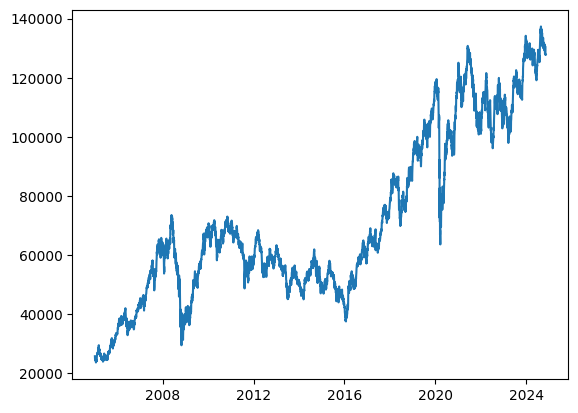

In [ ]:
# Nesse primeiro gráfico já podemos indentificar uma tendência de crescimento nos valores da bolsa, porém com quedas pontais em alguns anos.

plt.plot(df_ibov.index, df_ibov.Último)

In [ ]:
# Para verificar a sazonalidade, tendência e ruídos, vamos primeiro configurar a frequência do nosso dataframe para 'diário'.

df_ibov = df_ibov.asfreq('D')

# Feito isso vamos utilizar o método forward fill (ffill) para preencher possíveis valores ausentes, vamos utilizar esse método, pois os dias em que a bolsa não abriu (finais de semana, feriados...) vão ser preenchidos com os últimos valores.

df_ibov = df_ibov.fillna(method='ffill')

# Agora podemos realizar a nossa decomposição sazonal.

dec = seasonal_decompose(df_ibov['Último'], model='additive', period=365)

<ipython-input-19-7ca370f358ec>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ibov = df_ibov.fillna(method='ffill')


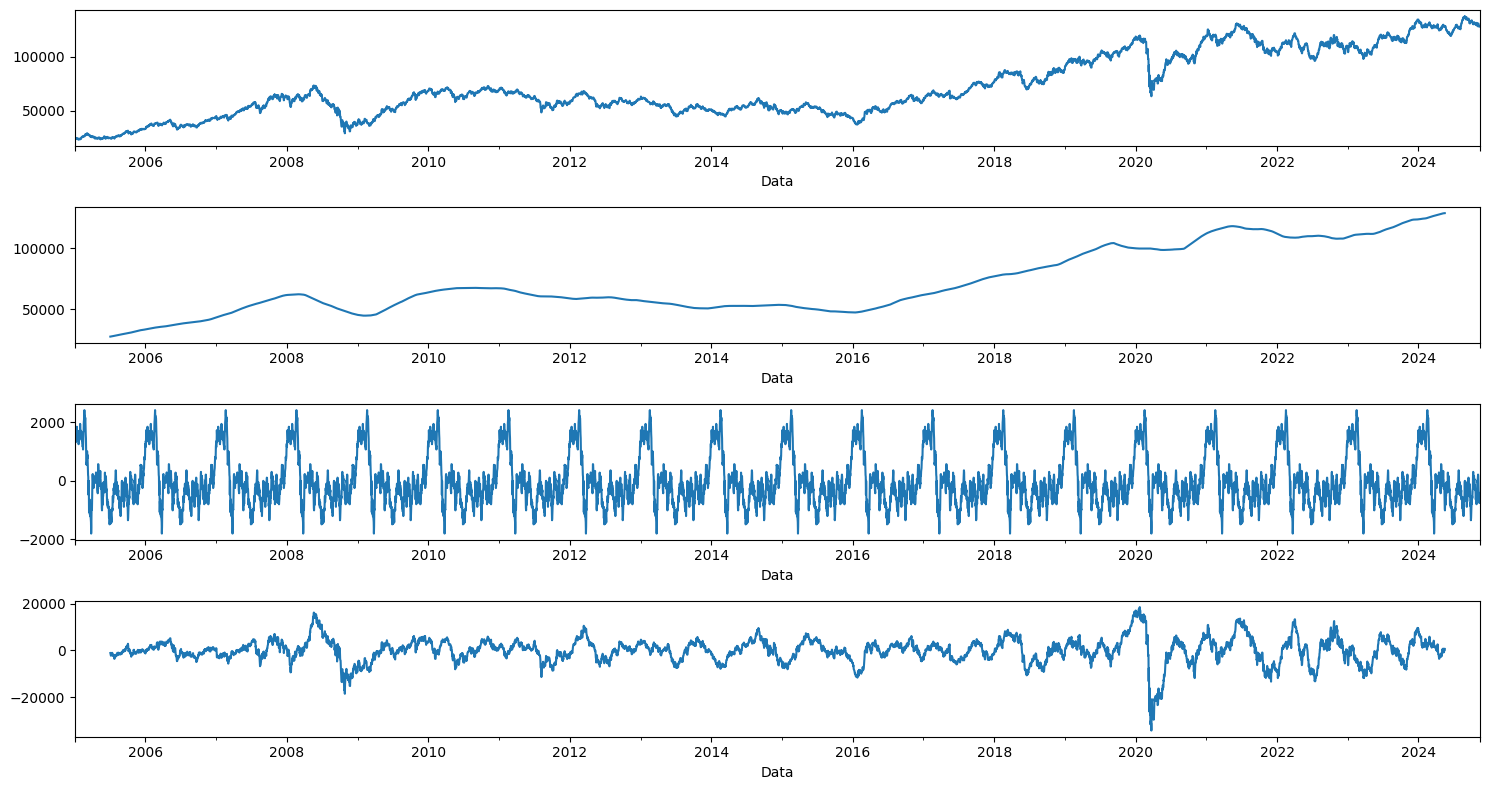

In [ ]:
# Com a decomposição, podemos ver com certeza a existência de uma tendência de crescimento ao longo dos anos, e uma sazonalidade mais clara.
# Outro ponto é que conseguimos ver valores de ruído mais expressivos nos anos de 2008 e 2020, que foram respectivamente anos de crises econômicas e de pandêmia global.

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
dec.observed.plot(ax=ax1)
dec.trend.plot(ax=ax2)
dec.seasonal.plot(ax=ax3)
dec.resid.plot(ax=ax4)

plt.tight_layout()

In [ ]:
# Vamos prosseguir realizando o teste ADF (Augmented Dickey-Fuller), para verificar se nossa série é estacionaria ou não.

x = df_ibov.Último.values

result = adfuller(x)

print('Teste ADF')
print(f'Teste Estatístico: {result[0]}')
print(f'P-Value: {result[1]}')
print('Valores críticos:')

for key, value in result[4].items():
  print(f'\t{key}: {value}')

Teste ADF
Teste Estatístico: -1.2510301983152563
P-Value: 0.6512679511781277
Valores críticos:
	1%: -3.431253538677303
	5%: -2.8619392935870853
	10%: -2.566982539776716


Como o nosso p-valor foi de 65,13%, e o teste estatístico maior que os valores críticos, então essa série não é estacionária.

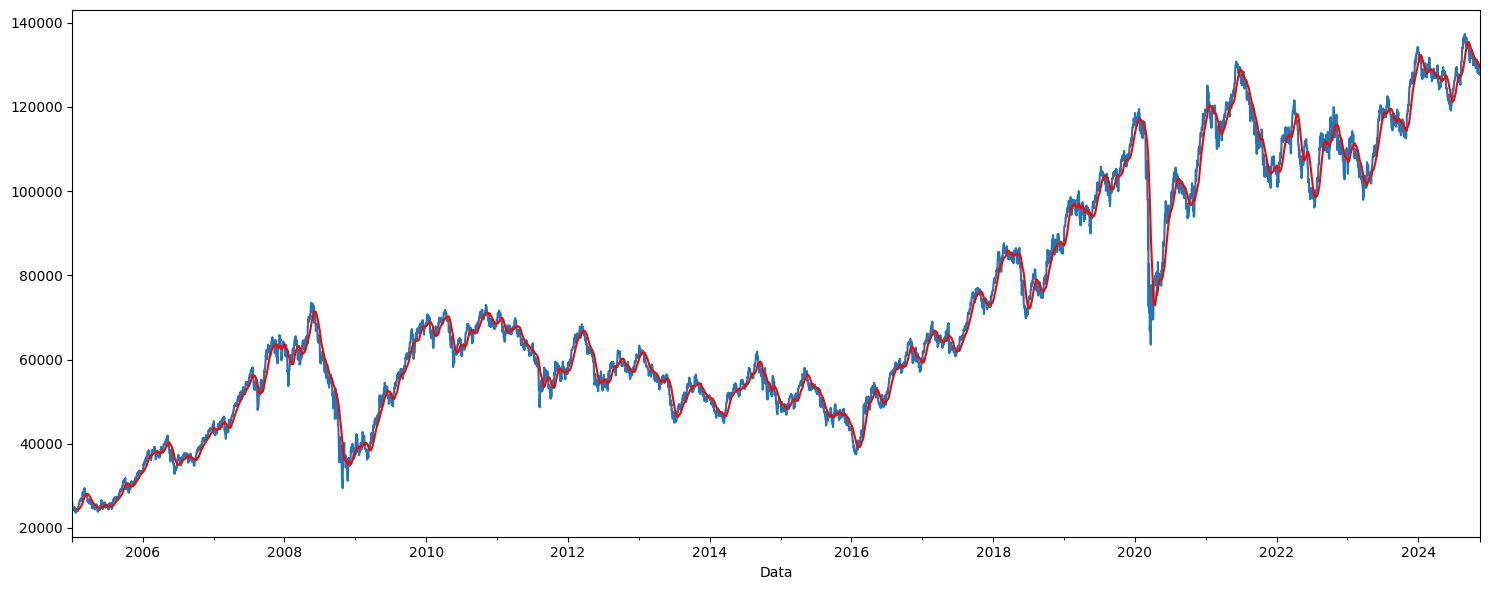

In [ ]:
# Como nossa série não é estacionária, vamos trabalhar com uma média móvel, e fazer trasnformações logaritmicas e de diferenciação, para tentar torná-la estacionária.

ma = df_ibov['Último'].rolling(30).mean()

f, ax = plt.subplots()
df_ibov['Último'].plot(ax=ax, legend=False, figsize=(15, 6))
ma.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

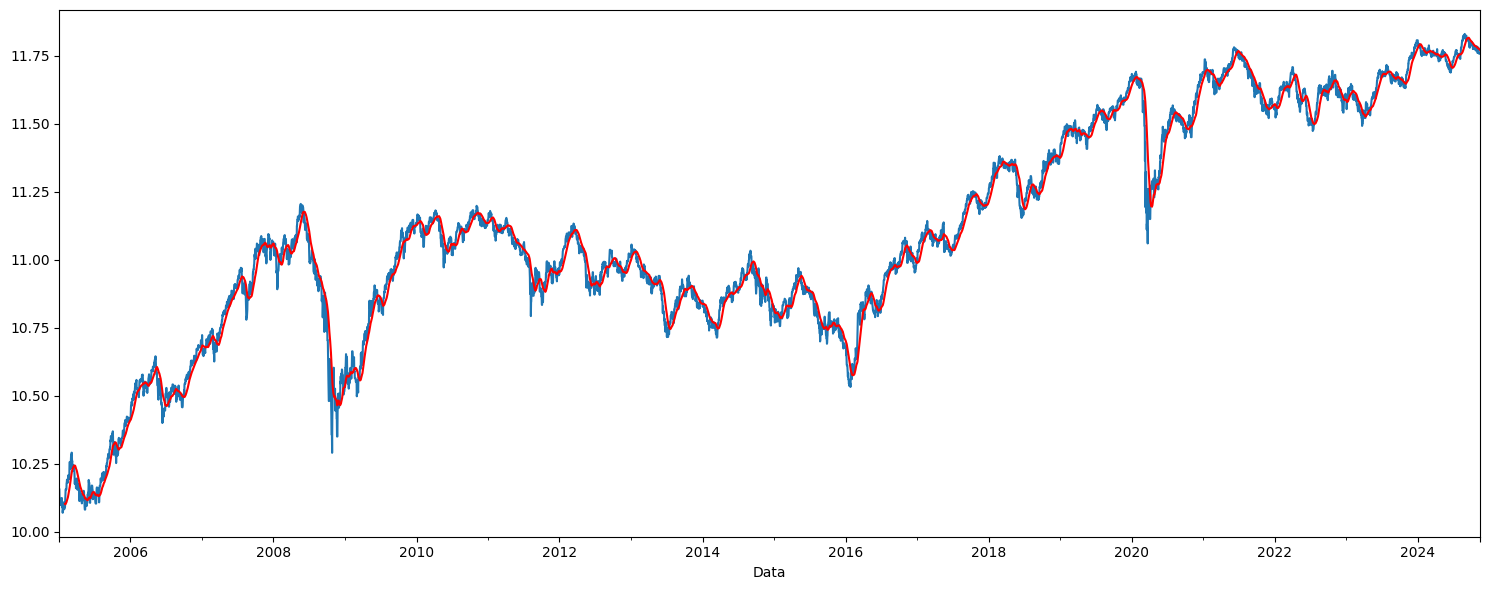

In [ ]:
# Primeiro a transformação em escala de log, onde já temos uma boa redução da escala.

df_ibov_log = np.log(df_ibov['Último'])
ma_log = df_ibov_log.rolling(30).mean()

f, ax = plt.subplots()
df_ibov_log.plot(ax=ax, legend=False, figsize=(15, 6))
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

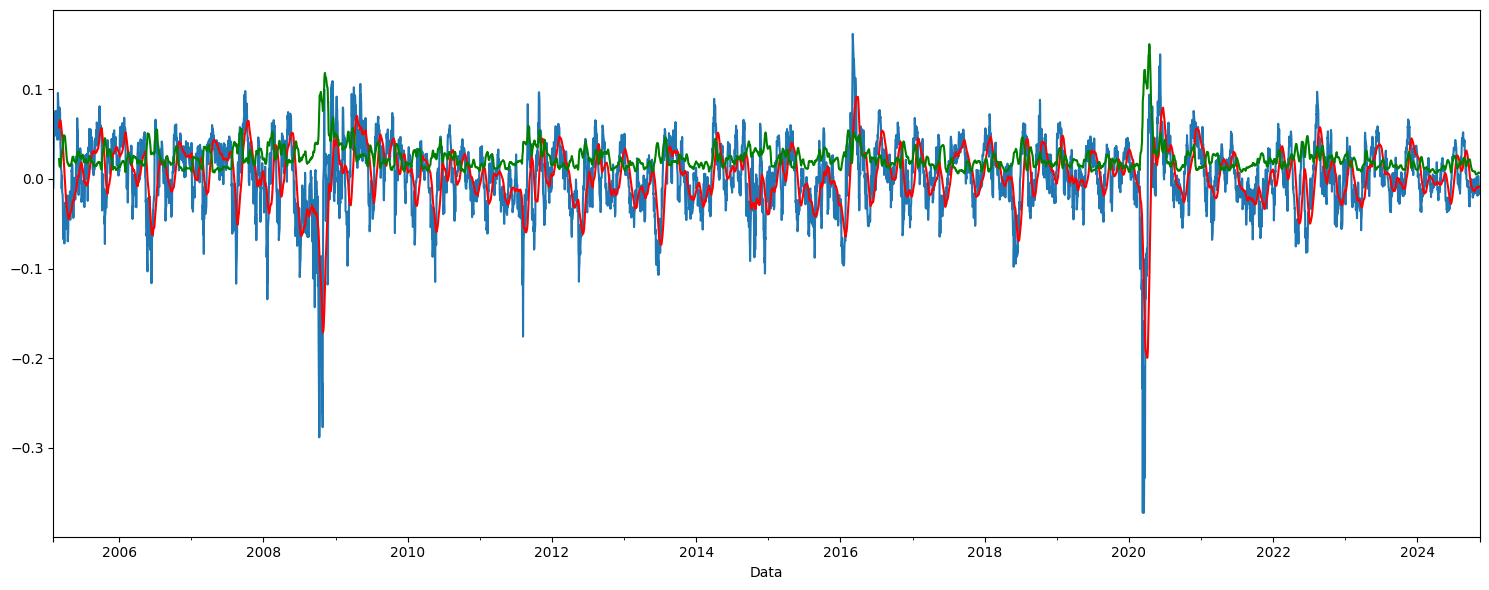

In [ ]:
# Agora realizamos a subtração da escala com log.

df_ibov_sub = (df_ibov_log - ma_log).dropna()

ma_sub = df_ibov_sub.rolling(30).mean()

std = df_ibov_sub.rolling(30).std()

f, ax = plt.subplots()
df_ibov_sub.plot(ax=ax, legend=False, figsize=(15, 6))
ma_sub.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

In [ ]:
# Com a transformação feita, podemos realizar o teste novamente.

x_sub = df_ibov_sub.values

result_sub = adfuller(x_sub)

print('Teste ADF')
print(f'Teste Estatístico: {result_sub[0]}')
print(f'P-Value: {result_sub[1]}')
print('Valores críticos:')

for key, value in result_sub[4].items():
  print(f'\t{key}: {value}')

Teste ADF
Teste Estatístico: -11.67948246285795
P-Value: 1.7553669769161916e-21
Valores críticos:
	1%: -3.4312586863794188
	5%: -2.8619415681219382
	10%: -2.566983750547726


Agora o p-valor foi bem inferior a 5%, e o teste estatístico menor que os valores críticos, então nossa série é estacionária.

Teste ADF
Teste Estatístico: -20.27273908011282
P-Value: 0.0
Valores críticos:
	1%: -3.4312598242236394
	5%: -2.861942070882888
	10%: -2.5669840181754524


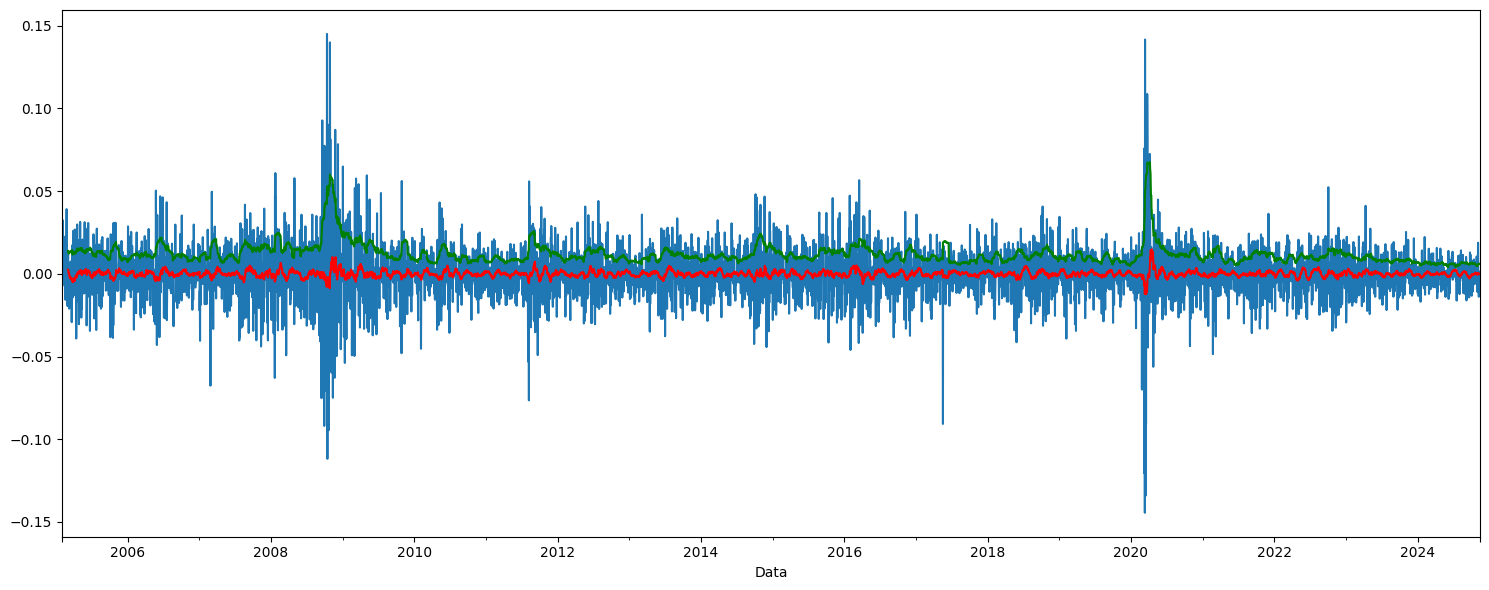

In [ ]:
# Caso seja necessário, é possível deixar a série ainda mais estacionária, trabalhando com diferenciação.

df_ibov_diff = df_ibov_sub.diff(1)
ma_diff = df_ibov_diff.rolling(30).mean()
std_diff = df_ibov_diff.rolling(30).std()

f, ax = plt.subplots()
df_ibov_diff.plot(ax=ax, legend=False, figsize=(15, 6))
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

x_diff = df_ibov_diff.dropna().values

result_diff = adfuller(x_diff)

print('Teste ADF')
print(f'Teste Estatístico: {result_diff[0]}')
print(f'P-Value: {result_diff[1]}')
print('Valores críticos:')

for key, value in result_diff[4].items():
  print(f'\t{key}: {value}')

Agora o nosso p-valor foi de 0, e nosso teste estatístico ficou ainda menor que os valores critícos.

Lembrando que muitos modelos estatísticos tradicionais de séries temporais, como o ARIMA, dependem que a série temporal seja estacionária, por isso as trasnformações acima foram necessárias.

In [ ]:
# Como conseguimos deixar a nossa série estacionária, podemos realizar os testes ACF e PACF (Autocorrelaçao e Autocorrelação parcial)

df_ibov_diff.head()

,Último
Data,
2005-02-01,NaN
2005-02-02,0.020187
2005-02-03,0.010839
2005-02-04,0.032537
2005-02-05,-0.001817


<function matplotlib.pyplot.show(close=None, block=None)>

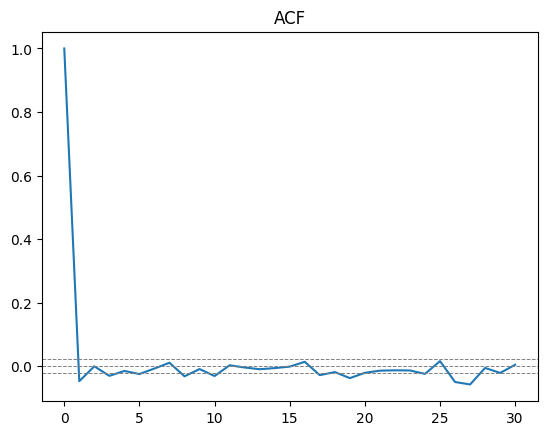

In [ ]:
# Aqui vamos selecionar um lag de 30 dias inicialmente, para puxar 1 mês inteiro, porém podemos alterar esse parâmetro caso necessário.

lag_acf = acf(df_ibov_diff.dropna(), nlags=30)

lag_pacf = pacf(df_ibov_diff.dropna(), nlags=30)

plt.plot(lag_acf)

plt.axhline(y=-1.96/(np.sqrt((len(df_ibov_diff)-1))), linestyle='--', color='gray', linewidth=0.7)

plt.axhline(y=0, linestyle='--', color='gray', linewidth=0.7)

plt.axhline(y=1.96/(np.sqrt((len(df_ibov_diff)-1))), linestyle='--', color='gray', linewidth=0.7)

plt.title('ACF')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

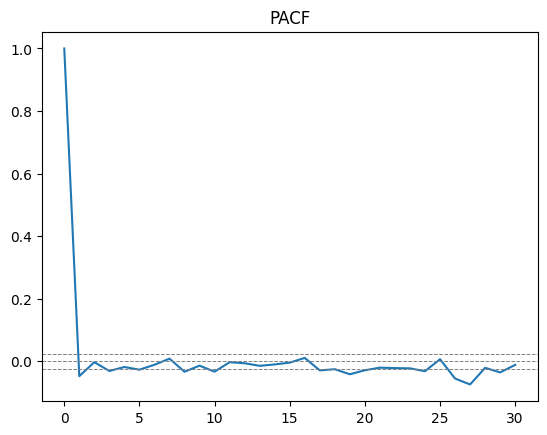

In [ ]:
plt.plot(lag_pacf)

plt.axhline(y=-1.96/(np.sqrt((len(df_ibov_diff)-1))), linestyle='--', color='gray', linewidth=0.7)

plt.axhline(y=0, linestyle='--', color='gray', linewidth=0.7)

plt.axhline(y=1.96/(np.sqrt((len(df_ibov_diff)-1))), linestyle='--', color='gray', linewidth=0.7)

plt.title('PACF')
plt.show

Podemos ver que os dois gráficos são bem parecidos.

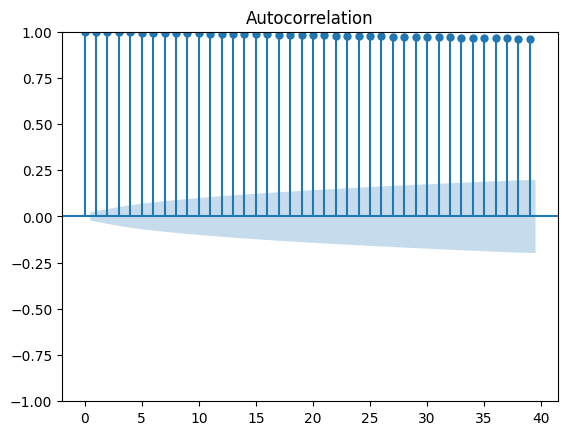

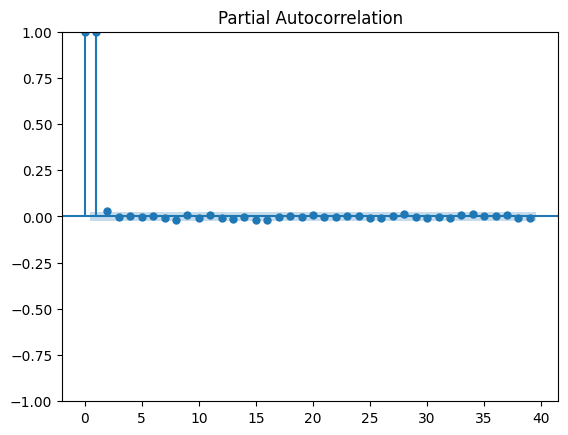

In [ ]:
plot_acf(df_ibov.Último)
plot_pacf(df_ibov.Último)
plt.show()

Podemos ver que na autocorrelação todos os nossos itens então fora do intervalo de confiança, enquanto na autocorrelação parcial occore o oposto, com a maioria dos dados dentro do intervalo de confiança.

Period: 7256.0 days


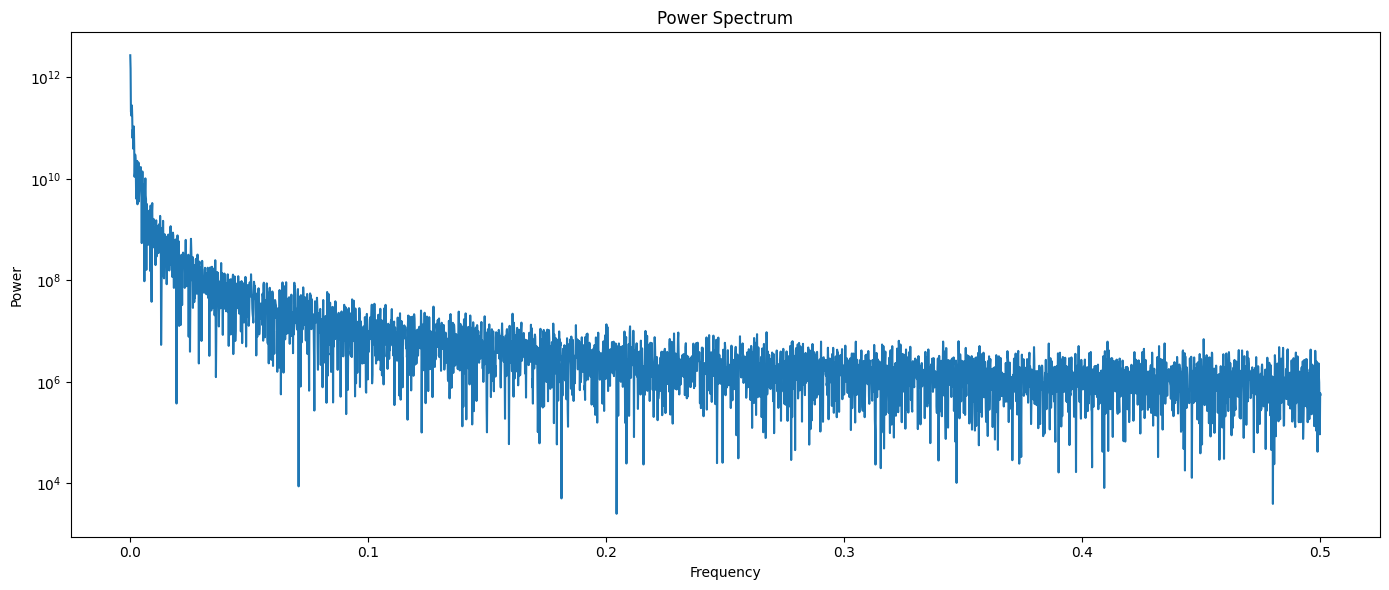

In [ ]:
# Por último vamos usar os termos de fourrier para verificar como outra maneira de verificar a sazonalidade.

frequency, power = periodogram(df_ibov['Último'].dropna(), fs=1)
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(frequency[1:], power[1:])
ax.set_title('Power Spectrum')
ax.set_xlabel('Frequency')
ax.set_ylabel('Power')
ax.set_yscale('log')
ax.get_figure().set_tight_layout(True)

freq = frequency[np.argmax(power)]
period = 1 / freq

print(f'Period: {period} days')

df_ibov['fourier_sin'] = np.sin(2 * np.pi * freq * np.arange(len(df_ibov)))
df_ibov['fourier_cos'] = np.cos(2 * np.pi * freq * np.arange(len(df_ibov)))

array([<Axes: xlabel='Data'>, <Axes: xlabel='Data'>], dtype=object)

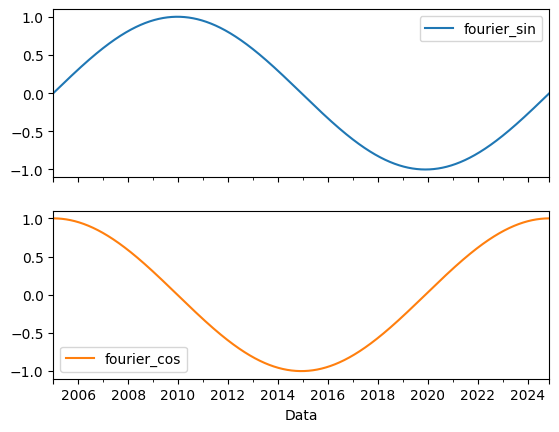

In [ ]:
# Como podemos ver abaixo, foi encontrada uma sazonalidade além da anual vista na decomposição, um dos motivos principais para o modelo identificar essas sazonalidade diferente é a crise de 2008, e o forte crescimento da bolsa a partir de 2016.

df_ibov[['fourier_sin', 'fourier_cos']].plot(subplots=True)

# Modelos

In [ ]:
# Com a análise exploratória finalizada, podemos seguir para a criação dos nossos modelos

df_ibov = df_ibov.reset_index()
df_ibov.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,fourier_sin,fourier_cos
0,2005-01-03,25722.0,26193.0,26492.0,25671.0,115640000.0,-0.0181,0.000000,1.000000
1,2005-01-04,24848.0,25722.0,25873.0,24791.0,146140000.0,-0.0340,0.000866,1.000000
2,2005-01-05,24692.0,24859.0,25001.0,24523.0,127420000.0,-0.0063,0.001732,0.999999
3,2005-01-06,24367.0,24695.0,24808.0,24250.0,151170000.0,-0.0132,0.002598,0.999997
4,2005-01-07,24747.0,24376.0,24874.0,24376.0,104960000.0,0.0156,0.003464,0.999994


In [ ]:
df_ibov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7256 entries, 0 to 7255
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Data         7256 non-null   datetime64[ns]
 1   Último       7256 non-null   float64       
 2   Abertura     7256 non-null   float64       
 3   Máxima       7256 non-null   float64       
 4   Mínima       7256 non-null   float64       
 5   Vol.         7256 non-null   float64       
 6   Var%         7256 non-null   float64       
 7   fourier_sin  7256 non-null   float64       
 8   fourier_cos  7256 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 510.3 KB


In [ ]:
# Renomear as colunas que vamos trabalhar, pois as bibliotecas exigem nomes específcos

df_ibov_model = df_ibov[['Data', 'Último', 'Vol.']]
df_ibov_model['Vol.'] = 'pontos'
df_ibov_model = df_ibov_model.rename(columns={'Data': 'ds', 'Último': 'y', 'Vol.':'unique_id'})
df_ibov_model

<ipython-input-35-60e896f50087>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ibov_model['Vol.'] = 'pontos'


,ds,y,unique_id
0,2005-01-03,25722.0,pontos
1,2005-01-04,24848.0,pontos
2,2005-01-05,24692.0,pontos
3,2005-01-06,24367.0,pontos
4,2005-01-07,24747.0,pontos
...,...,...,...
7251,2024-11-10,127830.0,pontos
7252,2024-11-11,127874.0,pontos
7253,2024-11-12,127698.0,pontos
7254,2024-11-13,127734.0,pontos


In [ ]:
df_ibov_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7256 entries, 0 to 7255
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         7256 non-null   datetime64[ns]
 1   y          7256 non-null   float64       
 2   unique_id  7256 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 170.2+ KB


In [ ]:
# Aqui selecionamos tudo anterior a agosto de 2024 para treino, e o período entre agosto de 2024 e catorze de novembro de 2024 para teste

treino = df_ibov_model.loc[df_ibov_model['ds'] < '2024-08-01']
valid = df_ibov_model.loc[(df_ibov_model['ds'] >= '2024-08-01') & (df_ibov_model['ds'] < '2024-11-14')]
h = valid['ds'].nunique()

In [ ]:
h

105

In [ ]:
# Vamos calcular o erro percentual médio

def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

/usr/local/lib/python3.11/dist-packages/numpy/_core/numeric.py:362: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


WMAPE: 3.33%


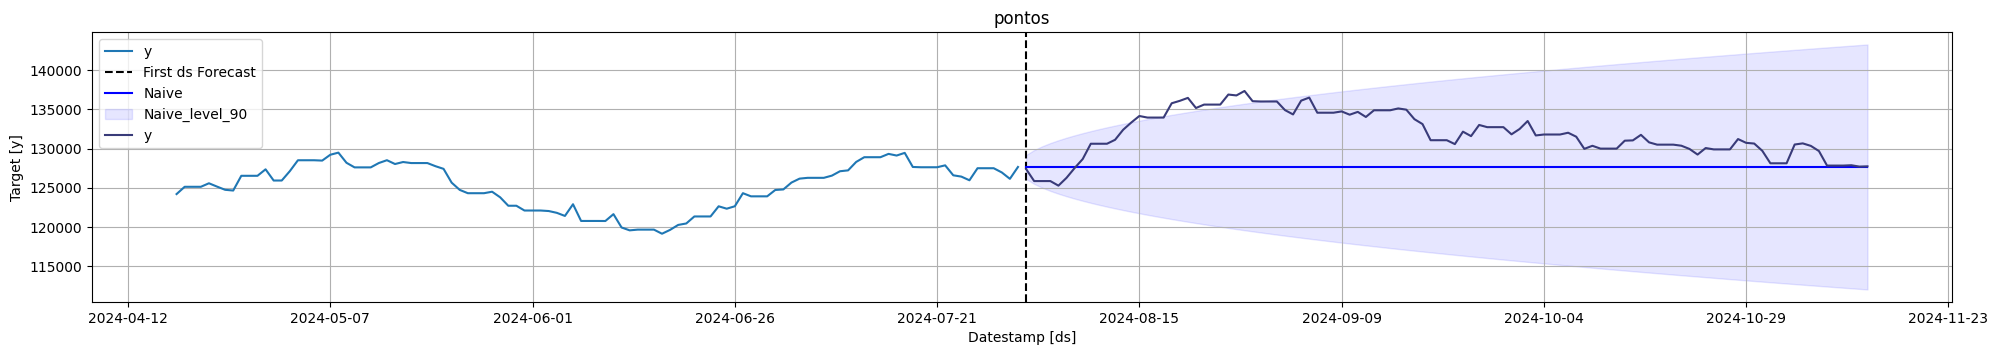

In [ ]:
# Modelo Naive

model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model.fit(treino)

forecast_df = model.predict(h=h, level=[90])
forecast_df = forecast_df.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape1 = wmape(forecast_df['y'].values, forecast_df['Naive'].values)
print(f"WMAPE: {wmape1:.2%}")

model.plot(treino, forecast_df, level=[90], unique_ids=['pontos'], engine ='matplotlib', max_insample_length=105)

/usr/local/lib/python3.11/dist-packages/numpy/_core/numeric.py:362: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


WMAPE: 3.56%


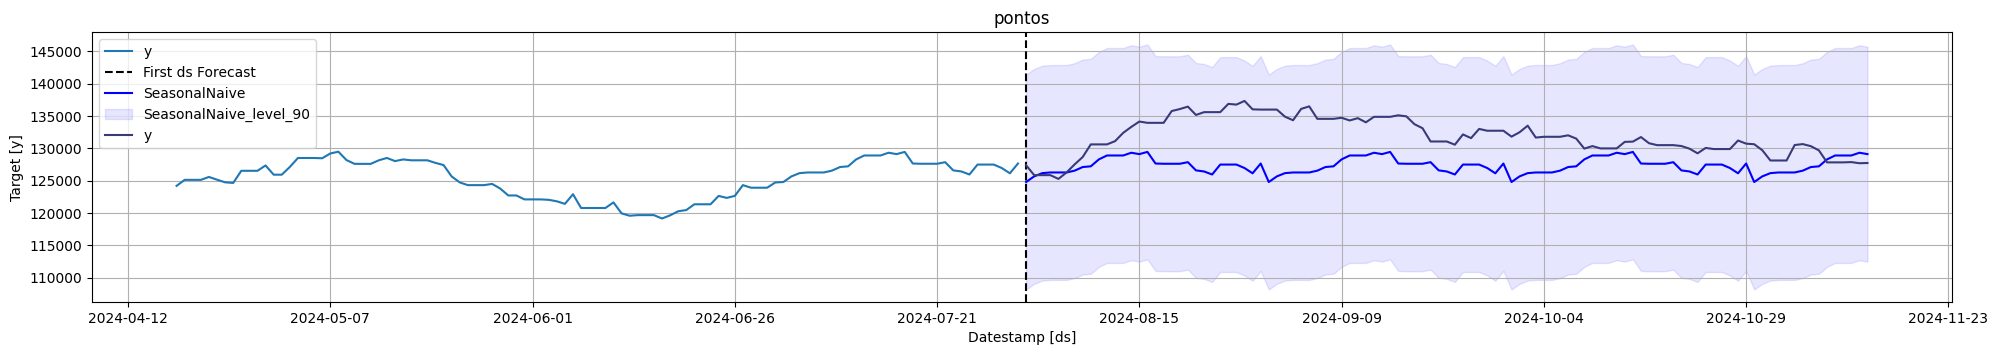

In [ ]:
# Modelo Seasonal Naive

model_s = StatsForecast(models=[SeasonalNaive(season_length=30)], freq='D', n_jobs=-1)
model_s.fit(treino)

forecast_dfs = model_s.predict(h=h, level=[90])
forecast_dfs = forecast_dfs.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape2 = wmape(forecast_dfs['y'].values, forecast_dfs['SeasonalNaive'].values)
print(f"WMAPE: {wmape2:.2%}")

model_s.plot(treino, forecast_dfs, level=[90], unique_ids=['pontos'],engine ='matplotlib', max_insample_length=105)

/usr/local/lib/python3.11/dist-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


WMAPE: 3.55%


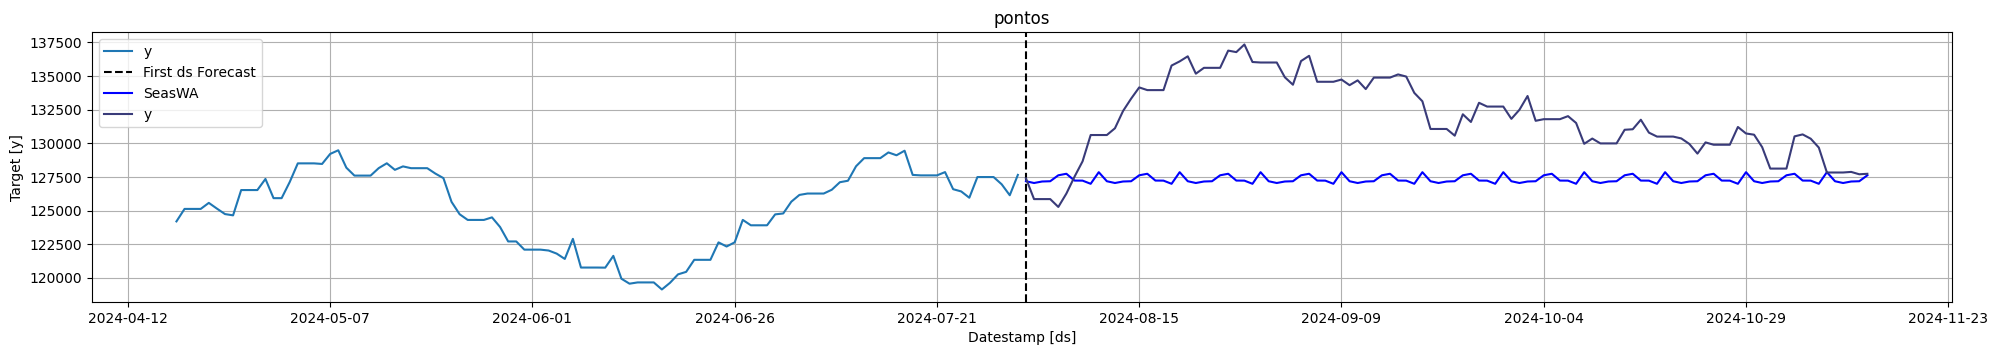

In [ ]:
# Modelo Seasonal Window Average

model_sm = StatsForecast(models=[SeasonalWindowAverage(season_length=10, window_size=3)], freq='D', n_jobs=-1)
model_sm.fit(treino)

forecast_dfsm = model_sm.predict(h=h, level=[90])
forecast_dfsm = forecast_dfsm.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape3 = wmape(forecast_dfsm['y'].values, forecast_dfsm['SeasWA'].values)
print(f"WMAPE: {wmape3:.2%}")

model_sm.plot(treino, forecast_dfsm, level=[90], unique_ids=['pontos'],engine ='matplotlib', max_insample_length=105)

/usr/local/lib/python3.11/dist-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


WMAPE: 3.39%


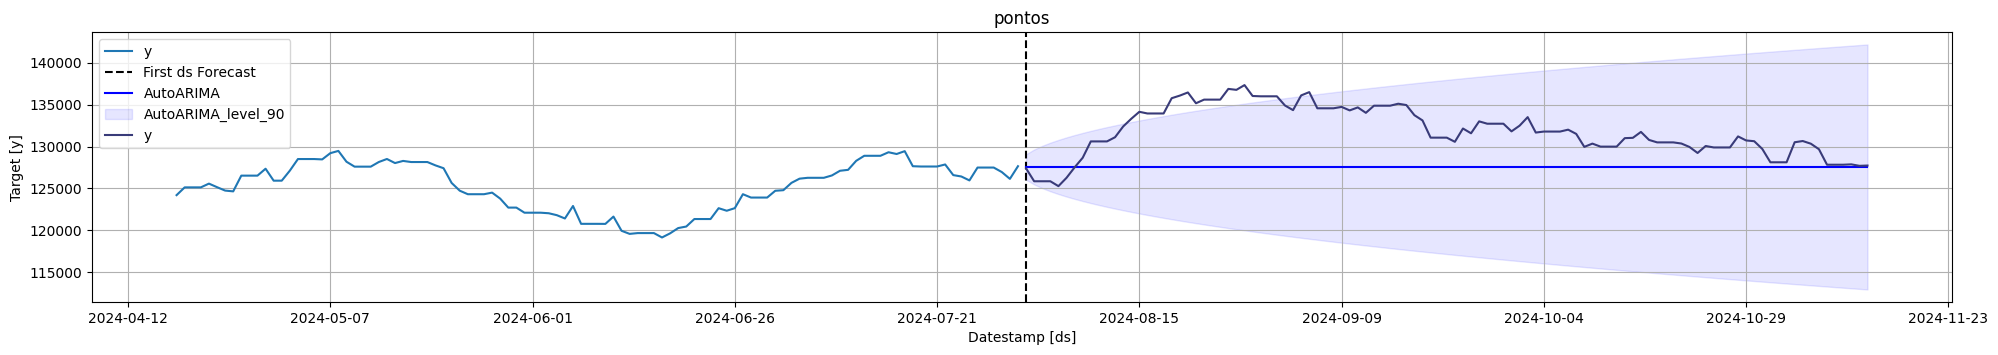

In [ ]:
# Modelo ARIMA

model_a = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
model_a.fit(treino)

forecast_dfa = model_a.predict(h=h, level=[90])
forecast_dfa = forecast_dfa.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape4 = wmape(forecast_dfa['y'].values, forecast_dfa['AutoARIMA'].values)
print(f"WMAPE: {wmape4:.2%}")

model_a.plot(treino, forecast_dfa, level=[90], unique_ids=['pontos'],engine ='matplotlib', max_insample_length=105)

In [ ]:
df_ibov_model

,ds,y,unique_id
0,2005-01-03,25722.0,pontos
1,2005-01-04,24848.0,pontos
2,2005-01-05,24692.0,pontos
3,2005-01-06,24367.0,pontos
4,2005-01-07,24747.0,pontos
...,...,...,...
7251,2024-11-10,127830.0,pontos
7252,2024-11-11,127874.0,pontos
7253,2024-11-12,127698.0,pontos
7254,2024-11-13,127734.0,pontos


In [ ]:
# Vamos fazer agora um processo de treinamento inclua uma estratégia de backtesting iterativa para o modelo ARIMA

# Passo 1 - Definir o conjunto de teste para os últimos 10 dias
ultimo_ano = df_ibov_model['ds'].max()
inicio_teste = ultimo_ano - pd.DateOffset(days=10)
treino = df_ibov_model[df_ibov_model['ds'] < inicio_teste]
teste = df_ibov_model[df_ibov_model['ds'] >= inicio_teste]

# Passo 2 - Inicializando uma lista para armazenar os erros
erros = []
previstos = []

# Passo 3 - Treinamento e teste iterativos
for i in range(len(teste)):
    # Definindo o subconjunto de treino até o dia de teste atual
    dado_treino_atual = pd.concat([treino, teste.iloc[:i]], ignore_index=False).copy()

    # Treinando o modelo ARIMA com hiperparâmetros encontrados
    model_a = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
    model_a.fit(dado_treino_atual)

    # Fazendo a previsão para o próximo dia de teste
    forecast = model_a.predict(h=1)

    # Avaliando o modelo
    valor_real = teste.iloc[i]['y']
    valor_previsto = forecast.iloc[0]['AutoARIMA']

    # Armazenar o valor previsto
    previstos.append(valor_previsto)

    # Calcular o erro percentual (MAPE)
    erro_percentual = abs((valor_real - valor_previsto) / valor_real) * 100
    erros.append(erro_percentual)

# Calculando MAPE e Acurácia
mape = np.mean(erros)
acuracia = 100 - mape

# Exibindo os resultados
print(f"MAPE: {mape:.2f}%")
print(f"Acurácia do modelo: {acuracia:.2f}%")

/usr/local/lib/python3.11/dist-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/usr/local/lib/python3.11/dist-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/usr/local/lib/python3.11/dist-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/usr/local/lib/python3.11/dist-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/usr/local/lib/python3.11/dist-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/usr/local/lib/python3.11/dist-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value

MAPE: 0.42%
Acurácia do modelo: 99.58%


/usr/local/lib/python3.11/dist-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


# Conclusão

In [ ]:
# Gerando um dataframe com o resultado das métricas de erro para cada modelo

resultados = pd.DataFrame(
    {
        "Modelo": ['Naive', 'Seasonal Naive', 'Seasonal Window Average', 'ARIMA', 'ARIMA + Backtesting'],
        "WMAPE": [f"{wmape1:.2%}", f"{wmape2:.2%}", f"{wmape3:.2%}", f"{wmape4:.2%}", f"{mape:.2f}%"],
        "Acuracidade": [f"{1-wmape1:.2%}", f"{1-wmape2:.2%}", f"{1-wmape3:.2%}", f"{1-wmape4:.2%}", f"{acuracia:.2f}%"],
    }
).set_index('Modelo').sort_values('WMAPE')

resultados

,WMAPE,Acuracidade
Modelo,,
ARIMA + Backtesting,0.42%,99.58%
Naive,3.33%,96.67%
ARIMA,3.39%,96.61%
Seasonal Window Average,3.55%,96.45%
Seasonal Naive,3.56%,96.44%


Conseguimos criar o modelo preditivo, e atingimos a acuracidade de 99,58% com o modelo ARIMA + Backtesting